# Recommendations Systems
## Assignment 2: Content Based Recommendations 

**By:**  
Group #16

<br><br>

**The goal of this assignment is to:**
- Understand the details of content based recommender systems
- Understand pros & cons comparing to other recommender system approaches
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ and up should be used.  
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).


**Grading:**
- Q1 - 10 points - Data exploration
- Q2 - 30 points - Item similarity
- Q3 - 40 points - Content based recommendation  
- Q4 - 20 points - Content based vs. matrix factorization comparison

`Total: 100`

**Prerequisites**

In [1]:
%pip install --quiet zipfile36
%pip install --quiet wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS

# metrics - do not use these metrics directly except for validating your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [3]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [5]:
random.seed(123)

# Question 1: 
# Data exploration 

In this exercise you will use the same dataset that we used for exercise #1:  [MovieLens 100K rating dataset](https://grouplens.org/datasets/movielens/100k/)  use Fold #2

Include additional exploration that is relevant for content based recommendation:

Explore at least 3 features.  
For example, explore the genres, titles, and you may also use [IMDB's API](https://developer.imdb.com/documentation/api-documentation/) to include additional features.  
 
Use plots and discuss your insights and possible challenges related to the dataset.


In [6]:
data_dir= '..\HW1\ml-100k\\'
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
df_actors= pd.read_csv('actorfilms.csv')

### Age of movie
We have the release date from which we can calculate the age of the movie as per the 1998 (the "youngest movie of in this dataset).

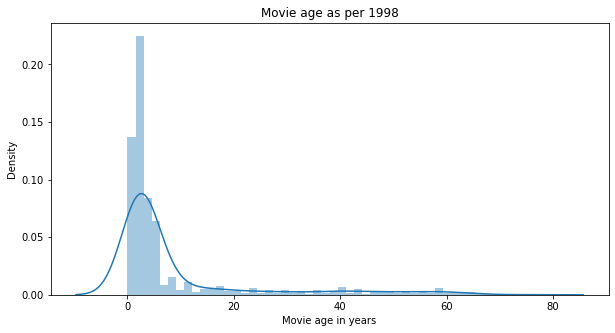

Median age of the movies is 3.0 years


In [7]:
#  detail movies by year of release
df_items['release_date'].fillna('0000', inplace=True)
df_items['ReleaseYear'] = df_items['release_date'].str[-4:].astype(int)
# get max year
max_year = df_items['ReleaseYear'].max()
df_items['MovieAge'] = max_year - df_items['ReleaseYear'].astype(int)
# plot average movie rating histogram
plt.figure(figsize=(10,5))
sns.distplot(df_items[df_items['MovieAge']< 100]['MovieAge'],kde=True, bins=50)
plt.title(f'Movie age as per {max_year}')
plt.xlabel('Movie age in years')
plt.show()
# find median movie age
median_age = df_items['MovieAge'].median()
print(f'Median age of the movies is {median_age} years')

With a median age of the movies being 3.0 years, we can probably have this feature used to help in recommending movies.
This can help us understand if a user has a taste for older movies ot they prefer to watch new releases.

### Using movie tags as features

The length of the tags dataset is 3683, giving an average of 2.2 tags per movie.
The number of unique movies in the tags dataset is 1572, which is shorter than the length of the movies dataset(1682).
The number of movies in the tags dataset which appear in the movies dataset is 1045.
The most common tag in the tags dataset is "In Netflix queue" with 131 occurences.
This tag is probably not very informative, as it is a generic tag that can be applied to many movies. We will remove it moving forward.
The median count of tagmentions per movie is userId       1.0
movieId      1.0
timestamp    1.0
dtype: float64.


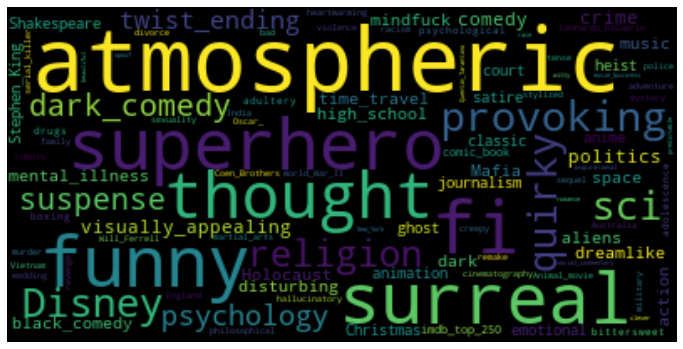

In [8]:
# the movie lens DB also has a tags dataset
df_tags= pd.read_csv('tags.csv')
print(f'The length of the tags dataset is {len(df_tags)}, giving an average of {round(len(df_tags)/len(df_items),1)} tags per movie.')
print(f'The number of unique movies in the tags dataset is {len(df_tags.movieId.unique())}, which is shorter than the length of the movies dataset({len(df_items)}).')
print(f'The number of movies in the tags dataset which appear in the movies dataset is {len(df_tags[df_tags.movieId.isin(df_items["movie id"])])}.')
print(f'The most common tag in the tags dataset is "{df_tags.tag.value_counts().index[0]}" with {df_tags.tag.value_counts()[0]} occurences.')
print('This tag is probably not very informative, as it is a generic tag that can be applied to many movies. We will remove it moving forward.')
# remove the most common tag
df_tags = df_tags[df_tags.tag != df_tags.tag.value_counts().index[0]]
print(f'The median count of tagmentions per movie is {df_tags.groupby("tag").count().median()}.')
# wordcloud of the movie tags can help us visualize the most popular tags
text = " ".join(tag.replace(" ", "_") for tag in df_tags.tag)
stopwords = set(STOPWORDS)
# Create and generate a word cloud image:
wordcloud = WordCloud(collocations=False, max_words=100).generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# df_tags.groupby("tag").count()['movieId'].sort_values(ascending=False).head(10)

The length of the tags dataset is 3683, giving an average of 2.2 tags per movie.</br>
The number of unique movies in the tags dataset is 1572, which is shorter than the length of the movies dataset(1682).</br>
The number of movies in the tags dataset which appear in the movies dataset is 1045.</br>
The most common tag in the tags dataset was "In Netflix queue" with 131 occurences.</br>
This tag is probably not very informative, as it is a generic tag that can be applied to many movies. We will removed it.</br>
We end up with a nice set of tags, allowing for a glimpse into what emotions these movies provoke in users.</br>
So if you like "surreal", "atmospheric" or "funny" movies, we got you covered!

In [10]:
# only keep movies in df_tags which are in df_items
df_tags = df_tags[df_tags.movieId.isin(df_items["movie id"])]
df_tags

,userId,movieId,tag,timestamp
10,18,431,Al Pacino,1462138765
11,18,431,gangster,1462138749
12,18,431,mafia,1462138755
13,18,1221,Al Pacino,1461699306
14,18,1221,Mafia,1461699303
...,...,...,...,...
3590,599,924,tedious,1498456814
3591,599,924,visual,1498456799
3592,599,924,visually appealing,1498456760
3672,600,273,gothic,1237739064


### gathering actors information per movie

In [27]:
#  movies and actors. we can do a pivot table to get the actors per movie
df_actors= pd.read_csv('actorfilms.csv')
df_actors['movie_title']= df_actors['Film']+ ' ('+ df_actors['Year'].astype(str)+ ')'
df_actors= df_actors.merge(df_items[['movie id','movie_title']],how='right',left_on='movie_title',right_on='movie_title').copy()
print('movies with Steve Buscemi!!!:')
print(df_actors[df_actors['Actor']=='Steve Buscemi']['movie_title'].unique().tolist())
df_actors.drop(['Film','Year', 'Votes','ActorID', 'FilmID'],axis=1,inplace=True)
df_actors['fewHot']= 1
df_actorsPivot= df_actors.pivot_table(index = ['movie id','movie_title'], columns ='Actor',fill_value=0, values='fewHot')
print(f'shape before trimming actors: {df_actorsPivot.shape}')
# only keep actors with more than 10 movies
df_actorsPivot= df_actorsPivot.loc[:,df_actorsPivot.sum()>10]
print(f'shape after trimming actors: {df_actorsPivot.shape}')
# only keep lines with some rating
df_actorsPivot= df_actorsPivot.loc[df_actorsPivot.sum(axis=1)>0]
print(f'shape after trimming movies: {df_actorsPivot.shape}')
print(f'number of movies with no rating: {len(df_items)-len(df_actorsPivot)}. Better leave this dataset out of the analysis.')

movies with Steve Buscemi!!!:
['Desperado (1995)', 'Billy Madison (1995)', 'Pulp Fiction (1994)', 'Fargo (1996)', 'Kansas City (1996)', 'Reservoir Dogs (1992)', "Miller's Crossing (1990)", 'Rising Sun (1993)', 'Escape from L.A. (1996)', 'Dead Man (1995)', 'Airheads (1994)', 'Con Air (1997)', 'Trees Lounge (1996)', 'Living in Oblivion (1995)', 'Somebody to Love (1994)', 'King of New York (1990)']
shape before trimming actors: (975, 3086)
shape after trimming actors: (975, 37)
shape after trimming movies: (342, 37)
number of movies with no rating: 1340. Better leave this dataset out of the analysis.


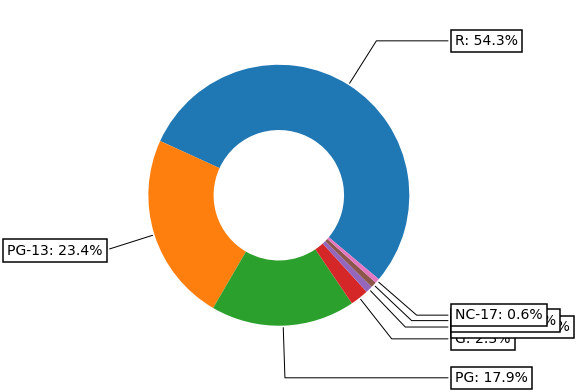

In [28]:
# // this dataset has directors, writers, parental guidance ratings, starts, country company and runtime!
df_moviesHeader= pd.read_csv('moviesHeader.csv')
df_moviesHeader['movie_title']= df_moviesHeader['name']+ ' ('+ df_moviesHeader['year'].astype(str)+ ')'
df_moviesHeader= df_moviesHeader.merge(df_items[['movie id','movie_title']],how='right',left_on='movie_title',right_on='movie_title').copy()
df_moviesHeader= df_moviesHeader.drop(['name','year','movie_title', 'released'],axis=1)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
GB= df_moviesHeader['rating'].value_counts()
GBSum= GB.sum()
RIdx= GB.index.tolist()
RCount = GB.values.tolist()
RDesc= [RIdx[i]+': '+str(round( 100* RCount[i]/GBSum, 1))+ "%" for i in range(len(RIdx))]
wedges, texts = ax.pie(RCount, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1.5)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(RDesc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=14)

ax.set_title("Age ratings", fontsize=24, fontdict={'fontweight':'bold', 'color': 'white'})
plt.show()

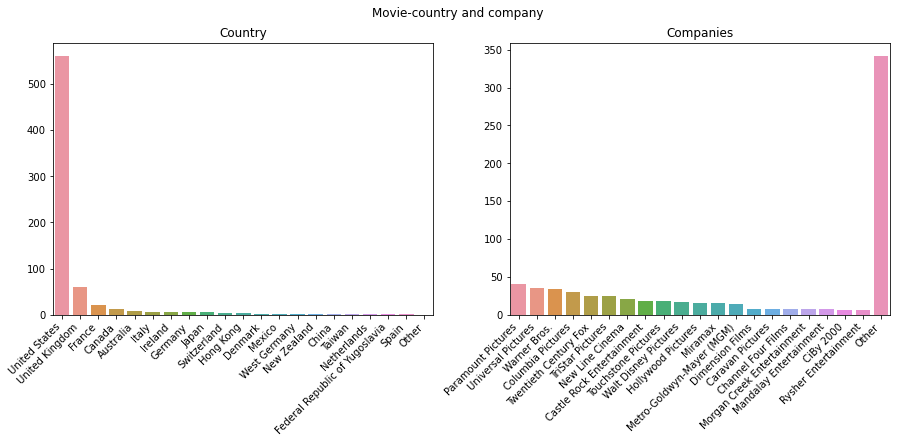

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Movie-country and company')
keepTop= 20
GB= df_moviesHeader['country'].value_counts()
GBIdx= GB.index[:keepTop].append(pd.Index(['Other']))
GBValues= GB.values[:keepTop].tolist()
GBValues.append(GB.values[keepTop:].sum())
sns.barplot(ax=axes[0], x=GBIdx, y=GBValues)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[0].set_title('Country')

GB= df_moviesHeader['company'].value_counts()
GBIdx= GB.index[:keepTop].append(pd.Index(['Other']))
GBValues= GB.values[:keepTop].tolist()
GBValues.append(GB.values[keepTop:].sum())
sns.barplot(ax=axes[1], x=GBIdx, y=GBValues)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_title('Companies')
fig.show()

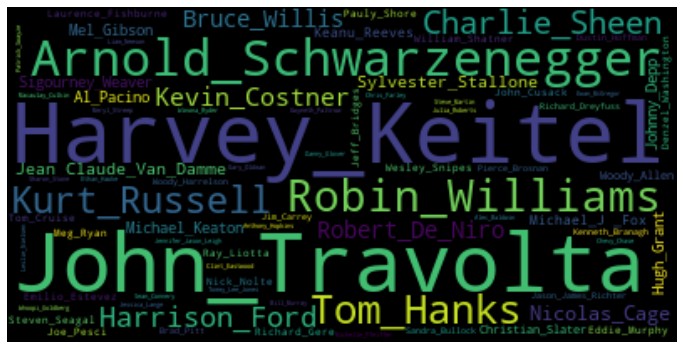

In [24]:
#  wordcloud of actors
text = " ".join(star.replace(" ", "_") for star in df_moviesHeader.star if type(star) is str)
stopwords = set(STOPWORDS)
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
#  set plt size
plt.figure(figsize=(12,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

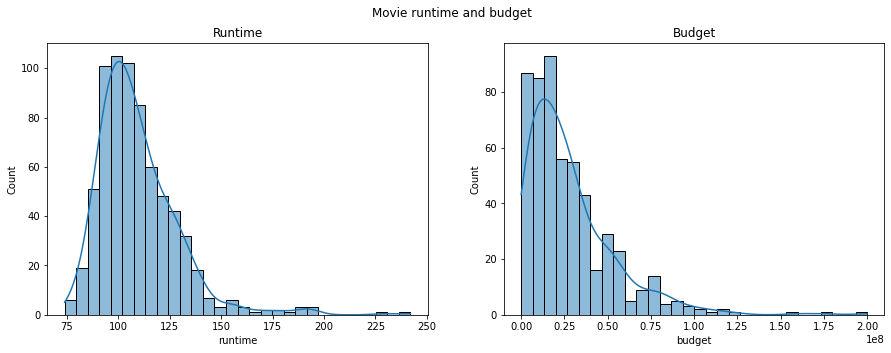

In [33]:
# histogram of runtimes, budget 
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Movie runtime and budget')
sns.histplot(ax=axes[0], x=df_moviesHeader['runtime'], bins=30, kde=True)
axes[0].set_title('Runtime')
sns.histplot(ax=axes[1], x=df_moviesHeader['budget'], bins=30, kde=True)
axes[1].set_title('Budget')
fig.show()



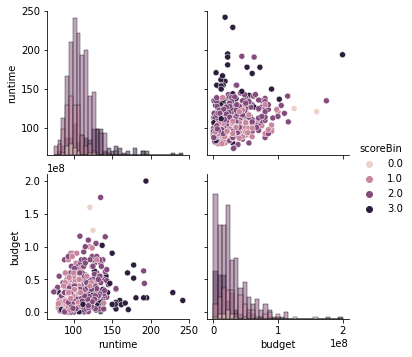

In [42]:
# df_moviesHeader.info()
#  get the effect of the rating, star, country, company, runtime, budget on the score
df_moviesHeader['scoreBin']= pd.cut(df_moviesHeader['score'], bins=4, labels=False)
sns.pairplot(df_moviesHeader[['scoreBin','runtime','budget']], hue='scoreBin', diag_kind='hist')


<br><br><br><br><br><br>
# Question 2:
# Item Similarity

The following blog posts [link1](https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7), [link2](https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e), will be helpful for answering questions 2 and 3. 

Please provide code and explanations for your answer.  
In case you don't have a clear answer, please provide your best hypothesis.

### Build a movie profile vector based on the item features of your choice. 
Select at least two features from the dataset. Describe the potential contribution of each feature to a content based model.

Tip: When looking on the MovieLens dataset its features vector will include `genres`, `title`, etc.

In [18]:
df_items2= df_items.merge(df_moviesHeader,how='left',left_on='movie_title',right_on='movie_title').copy()
# df_items2= df_items2.merge(df_actors,how='left',left_on='movie id',right_on='movie id').copy()
df_items2

NameError: name 'df_moviesHeader' is not defined

In [ ]:
# example
# irrelevant_cols = []
# movies_profile = df_items.drop(irrelevant_cols,axis=1)



### Build a function which provides the 5 most similar items to an input item (item_id). 
Please use `Cosine Similarity` metric to calculate Item to item similarity.  
Notice: while it is a great way to debug your code, make sure not to return the actual input `item_id` in your results.


In [ ]:
def get_similar_items(..., item_id, n=5):
    ''' 
    item_id : target item 
    n : number of similar items to return
    
    This function returns a dataframe\array with ids of n most similar items to the target item and the similarity score
    '''
    
    
    return most_similar_items_id, most_similar_item_score

### Use the above function to find the 5 most similar items for any 2 items from the dataset. 
Please discuss the results you got. Are there any issues with the quality of the results? 

Please add the movie's title and image to your explanation.

In [ ]:
# first

In [ ]:
# second

<br><br><br><br><br><br>
# Question 3:
# Content based recommendation



### Build a function which recommends n=5 most relevant items to a user. 

In [ ]:
def get_item_recommendations(..., user_id, n=5):
    ''' 
    user_id: id of target user
    n : number of recommended items
    
    This function returns a dataframe\array with ids of n recommended items and their scores
    '''


    return recommended_items_ids,recommended_items_score
    

### Test your recommender system on 2 users. Explain your results.

In [ ]:
# TIP: try using code similar to the following for plotting your results
# user_id = 9  
# items, score = get_item_recommendations(users_profile,movies_profile,user_id)  

# fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
# users_profile.loc[user_id].plot(kind='bar',ax=axes[0]);  
# movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1]);  
# plt.legend(df_items.loc[df_items.index.isin(items)].movie_title);

### Use the MRR metric to evaluate your recommender system on the test set. 
Use a cutoff value of 5.

<br><br><br><br><br>
# Question 4
# Content based recommendations vs. Matrix Factorization

### Use MF's  item representation to find the most similar items
Use the matrix factorization item representation you built in exercise 1 to find the most similar items for **the same 2 items** you used above. 
(Use your optimal hyperparams and resulting model)

Compare the results you got using the different methods below and discuss your findings

In [ ]:
# we recommend creating - class MF

In [ ]:
# find similar items to the same two items you chose
pass

### Use MF implementation for item recommendations 

Use the matrix factorization implemention from exercise 1 to recommend 5 items to **the same 2 users** you used above. 
(Use your optimal hyperparams and resulting model)

Compare the results you got using the different methods. Discuss your findings

### Compare the results of the content based recommender system to the matrix factorization recommender system

- Please use the same train and test set. 
- Please use the MRR metric for the comparison (provide a comparison plot). 

### Advantages & Disadvantages 

Please use the following table to discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems.
Please address the following aspects in your discussion, and feel free to add your own.

<table>
    <thead>
        <tr>
            <th>..</th>
            <th style="text-align:center">Content-Based</th>
            <th style="text-align:center">Matrix-Factorization</th>
            <th style="text-align:left">Notes:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Dimensionality</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Similarity</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Tranining Complexity</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Inference Complexity</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Explanability</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Scalability</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>        
        <tr>
            <td>New User</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>New Item</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Train Time</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Predict Time</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Deterministic</td>
            <td style="text-align:center"></td>
            <td style="text-align:center"></td>
            <td style="text-align:left"></td>
        </tr>
    </tbody>
</table>

<br>

Good Luck :)